# Use pure pytorch tensor to build a neural network

In [ ]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

# Generate sample data

In [ ]:
def get_true_labels(X, weights_true, bias_true):
  return (-3 * X ** 2) @ weights_true.T + X @ weights_true.T + bias_true.T

In [ ]:
n_samples = 150
input_dim = 3
output_dim = 2

torch.manual_seed(123)
max = 1
min = -1
X = (max - min) * torch.rand((n_samples, input_dim)) + min
print('Sample X: ' + str(X[:2]))

weights_true = torch.tensor([[5., 1., -10.], [-2., -6., 1.]])
bias_true = torch.tensor([[1.], [1.]])

y_true = get_true_labels(X, weights_true, bias_true)
print('Sample y: ' + str(y_true[:2]))

Sample X: tensor([[-0.4078,  0.0331, -0.4967],
        [ 0.3771, -0.8521,  0.7330]])
Sample y: tensor([[ 8.8634,  1.3976],
        [ 6.5125, 18.4003]])


# Plot data

In [ ]:
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

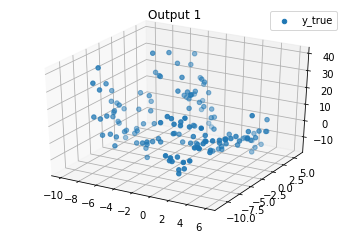

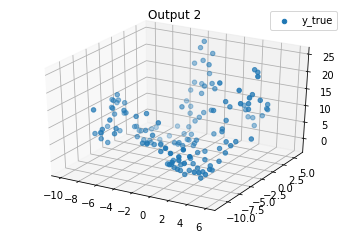

In [ ]:
plot_3d('Output 1', X, y_true[:,0])
plot_3d('Output 2', X, y_true[:,1])

# Build neural network

In [ ]:
# Mean Squared Error
class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
  
  def get_error(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient

class Layer:
  def __init__(self, num_input_nodes=1, num_output_nodes=1, activation=None):
    self.num_input_nodes = num_input_nodes
    self.num_output_nodes = num_output_nodes
    # Init layer with random weights and bias
    self.weights = (max - min) * torch.rand((num_input_nodes, num_output_nodes)) + min
    self.bias = torch.rand((1))
    self.X = torch.zeros((num_input_nodes))
    # Set activation function
    if activation == 'relu':
      self.activation = Relu()
    else: 
      self.activation = None
  
  def forward(self, X):
    self.X = X
    self.Z = X @ self.weights + self.bias
    # Pass output to activation function
    if self.activation == None:
      return self.Z 
    else:
      return self.activation.forward(self.Z)

  # Refered for math resource: https://www.kdnuggets.com/2019/08/numpy-neural-networks-computational-graphs.html
  # W = [[1, 4, 2],    <-- W1
  #      [2, -1, -2]]  <-- W2
  # f1(x, y, z) = w11 * x + w12 * y + w13 * z + b
  # f2(x, y, z) = w21 * x + w22 * y + w23 * z + b
  # Local Gradient:
  # df1/dw11 = x
  # df1/dw12 = y
  # df1/dw13 = z
  # df2/dw21 = x
  # df2/dw22 = y
  # df2/dw23 = z
  def backward(self, upstream_gradient):
    curr_upstream_gradient = upstream_gradient
    # Perform backpropagation on activation function first before backpropagation on weight and bias gradient
    if self.activation != None:
      curr_upstream_gradient = self.activation.backward(curr_upstream_gradient)
    
    # Compute the gradient of the weights wrt to loss by taking dot product of upstream gradient with local gradient
    self.dJdW = self.X.T @ curr_upstream_gradient
    # Bias is a constant so its derivative is 1 and the dot product of 1 and the upstream gradient is the sum of the gradient
    self.dJdb = curr_upstream_gradient.sum()
    # Compute the gradient of input X wrt to loss by taking dot product of upstream gradient with local gradient. 
    # This value is returned because it serves as the new "upstream" gradient in the previous layer
    self.dJdX = curr_upstream_gradient @ self.weights.T
    return self.dJdX

  # Update weight and bias params with learning rate step size
  def update(self, lr):
    self.weights = self.weights - lr * self.dJdW
    self.bias = self.bias - lr * self.dJdb

  def __str__(self):
    return 'Layer: ({},{}) Activation Function: {}\nInputs:\n{}\nWeights:\n{}\nBias:{}'.format(self.num_input_nodes, self.num_output_nodes, self.activation, self.X[:2], self.weights, self.bias)

class Relu:
  def __init__(self):
    self.input = torch.tensor([])

  def forward(self, input):
    self.input = input
    self.output = torch.clamp(self.input, min=0)
    return self.output
  
  # If input is less than 0, derivative is 0. If input is greater than 0, derivative is 1
  def backward(self, upstream_gradient):
    return (self.input > 0) * upstream_gradient
  
  # No update needed to ReLU members
  def update(self, lr):
    return

  def __str__(self):
    return 'ReLu'

class NeuralNet:
  def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs

    layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
    
    self.layers = []
    for i in range(len(layers[:-1])):
      # Don't add activation function to last layer because this is a regression problem
      if i == len(layers[:-1]) - 1:
        self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
      else:
        self.layers.append(Layer(layers[i], layers[i + 1], activation))

    # Print network architecture for debugging
    print('Neural Net Architecture:')
    for i, layer in enumerate(self.layers):
      print('=== Layer {} ==='.format(i))
      print(layer)
    print()

  def forward(self, inputs):
    curr_out = inputs
    for l in self.layers:
      curr_out = l.forward(curr_out)
    return curr_out
  
  def backward(self, y_pred, y_true):
    # Start with gradient from loss function wrt prediction
    mse = MSE(y_pred, y_true)
    error = mse.get_error()
    print('Error: ', mean_squared_error(y_true, y_pred.detach().numpy()))
    loss_gradient = mse.backward()

    # Pass dJ/dy to last layer of network and compute gradients at each layer backwards
    gradient = loss_gradient
    for layer in reversed(self.layers):
      gradient = layer.backward(gradient)
    
  def update(self, lr):
    for layer in self.layers:
      layer.update(lr)
  
  # Training loop over # of epochs
  def fit(self, X, y_true, epochs):
    for i in range(epochs):
      y_pred = self.forward(X)
      self.backward(y_pred, y_true)
      self.update(lr)

  def __str__(self):
    s = [str(layer) for layer in self.layers]
    return '\n'.join(s)

# Define hyperparameters

In [ ]:
epochs = 140
lr = 0.01

n_inputs = X.shape[1]
n_outputs = y_true.shape[1]

# Train neural network **with** ReLU activation

In [ ]:
nn = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation='relu')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: ReLu
Inputs:
tensor([0., 0.])
Weights:
tensor([[-0.2563, -0.8852,  0.3902,  0.3532],
        [ 0.1348,  0.6534, -0.4015,  0.9127],
        [-0.7622,  0.9017,  0.7430, -0.8895]])
Bias:tensor([0.4556])
=== Layer 1 ===
Layer: (4,3) Activation Function: ReLu
Inputs:
tensor([0., 0.])
Weights:
tensor([[-0.5380,  0.9840, -0.0417],
        [ 0.5890,  0.8646, -0.7711],
        [ 0.6079, -0.8699, -0.2701],
        [-0.4032, -0.9353, -0.9419]])
Bias:tensor([0.0179])
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
tensor([0., 0.])
Weights:
tensor([[-0.7735, -0.5588],
        [-0.3296,  0.5595],
        [-0.1608, -0.9901]])
Bias:tensor([0.1368])

Error:  125.53455
Error:  120.994095
Error:  117.09896
Error:  113.62822
Error:  110.46097
Error:  107.5071
Error:  104.71831
Error:  102.07132
Error:  99.48767
Error:  96.98197
Error:  94.59433
Error:  92.308624
Error:  90.03931
Error:  87.92551
Error:  86.05215
Erro

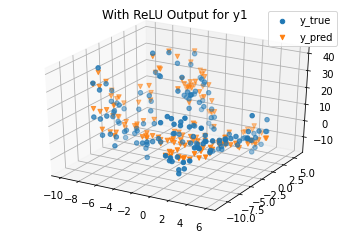

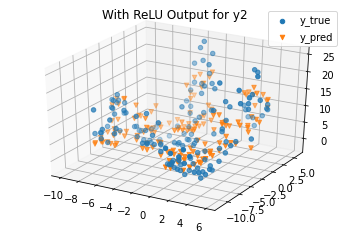

In [ ]:
plot_3d('With ReLU Output for y1', X, y_true[:,0], y_pred[:,0])
plot_3d('With ReLU Output for y2', X, y_true[:,1], y_pred[:,1])

# Train neural network **without** ReLU activation
We can see the error is much larger than the model trained with a nonlinear activation function and the resulting prediction plot does not look as close to the true values compared to the plot with ReLU.

In [ ]:
nn = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation=None)
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: None
Inputs:
tensor([0., 0.])
Weights:
tensor([[ 0.7177, -0.9758, -0.4919, -0.9050],
        [ 0.5380,  0.6835,  0.0875, -0.5027],
        [-0.2424,  0.0583,  0.4191,  0.0173]])
Bias:tensor([0.2669])
=== Layer 1 ===
Layer: (4,3) Activation Function: None
Inputs:
tensor([0., 0.])
Weights:
tensor([[ 0.0484,  0.0306,  0.0093],
        [ 0.4350, -0.3769,  0.0630],
        [ 0.0043,  0.4222, -0.6121],
        [-0.7818, -0.8139,  0.4201]])
Bias:tensor([0.8978])
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
tensor([0., 0.])
Weights:
tensor([[ 0.9918,  0.3571],
        [-0.2039,  0.1842],
        [-0.9889,  0.1154]])
Bias:tensor([0.3350])

Error:  119.6936
Error:  112.99363
Error:  106.304855
Error:  99.404205
Error:  92.64502
Error:  86.78379
Error:  82.48949
Error:  79.79791
Error:  78.15944
Error:  76.9758
Error:  75.907875
Error:  74.827866
Error:  73.70724
Error:  72.56093
Error:  71.428055
Error: 

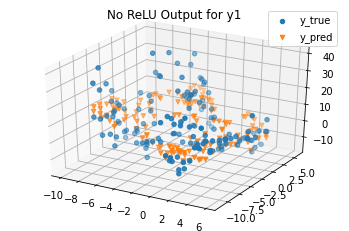

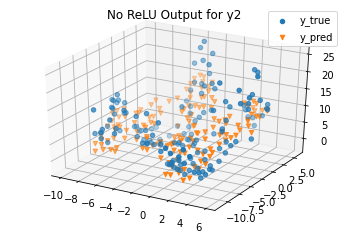

In [ ]:
plot_3d('No ReLU Output for y1', X, y_true[:,0], y_pred[:,0])
plot_3d('No ReLU Output for y2', X, y_true[:,1], y_pred[:,1])